## Notebook to code up method of moments framework 

Here, I will use the method of moments framework used to track the trajectory of the site frequency spectrum through time given drift and selection from [Jouganous et. al. 2017](https://www.genetics.org/content/206/3/1549). Mostly, I will just use equations to start from a certain generation $t$ back in time and then iterate until generation 0. Then I will store this SFS as a data entry for allele age $t$ and certain selection coefficient $s$. This process will be repeated for each value of $\{1,\ldots,gen,\ldots,12000\}$ generations. 

These vectors need to be summed to marginalize over *all* generations $a$, to give $P(X, a | s)$.

First, need to get a handle on what $\Phi_n^k(i)$ really is - can just be represented as *np.array*

$\phi_n^k(i)$ is the expected number of sites where the alternate allele is observed exactly $i$ times in a sample of size $n$ at generation $k$. 

In [513]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
from copy import deepcopy
import matplotlib.colors as colors
from numba import jit
from scipy.sparse import coo_matrix

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["figure.figsize"] = [5, 3.5]
plt.rcParams["figure.dpi"] = 110
plt.rcParams.update({"figure.facecolor": "white"})


In [860]:
N = 1000
# gamma = -np.exp(np.linspace(np.log(0.02),np.log(50),25))
s = -10/N # 25/N -> gamma = 50 - strong selection
mu = 1.25e-8 # human mutation rate
n = 10 # 2 * # of inds sampled, diploid

# start in generation 10 so generation 11 has all zeros (going back in time)
tot_gen = 10000

mom = np.zeros((tot_gen+1,n+1))
momnp1 = np.zeros(n+1)
momkp1 = np.zeros((tot_gen+1,n+1))

# double precaution - creating a mask
mk = [False] + [True]*(n-1) + [False]

iter = np.arange(1,n)
iterm1p1 = np.arange(2,n-1)

In [5]:
## borrowed directly from https://bitbucket.org/simongravel/moments/src/main/moments/Jackknife.pyx
def python2round(f):
    if round(f + 1) - round(f) != 1:
        return f + abs(f) / f * 0.5
    return round(f)

# The choice i' in n samples that best approximates the frequency of i/(n + 1) is i*n / (n + 1)
def index_bis(i, n):
    return int(min(max(python2round(i * n / float(n+1)), 2), n-2))

In [786]:
# code adapted from https://bitbucket.org/simongravel/moments/src/main/moments/Jackknife.pyx  
def calcJK13(n):
    J = np.zeros((n, 3))
    for i in np.arange(1,n+1):
        ibis = index_bis(i, n) 
        # beta
        J[i-1, 1] = (n+1) * ((i+1)*(n+2)*(i*(n+3)-n-6) - 2*(n+4)*(i*(n+2)-1)*ibis + (n**2+7*n+12)*ibis**2) / (n+2) / (n+3) / (n+4)

        # alpha
        J[i-1, 0] = 0.5 * (n+1) * (4+i**2*(6+5*n+n**2) - i*(14+9*n+n**2) - (n+4)*(2*i*(n+2)-n-5)*ibis + (n**2+7*n+12)*ibis**2) / (n+2) / (n+3) / (n+4)

        # gamma
        J[i-1, 2] = 0.5 * (n+1) * ((i+1)*(n+2)*(i*(n+3)-2) - (n+4)*(2*i*(n+2)+n+1)*ibis + (n**2+7*n+12)*ibis**2) / (n+2) / (n+3) / (n+4)

    return ([index_bis(i, n) for i in np.arange(1,n+1)], J)

ibis, jk13 = calcJK13(n)

In [861]:
## testbed for a single realization of gen = t
mom[tot_gen,1] = n*mu # singleton input

# going from generation 9 to 0
for gen in np.arange(tot_gen)[::-1]:
    momkp1[gen,iterm1p1] = 0.25/N * (mom[gen+1,iterm1p1-1] * (iterm1p1-1)*(n-iterm1p1+1) + mom[gen+1,iterm1p1+1] * (iterm1p1+1)*(n-iterm1p1-1) - mom[gen+1,iterm1p1] * 2*iterm1p1*(n-iterm1p1))

    momkp1[gen,1] = 0.25/N * ((n-2) * 2 * mom[gen+1,2] - 2 * (n-1) * mom[gen+1,1])
    momkp1[gen,n-1] = 0.25/N * ((n-2) * 2 * mom[gen+1,n-2] - 2 * (n-1) * mom[gen+1,n-1])

    # momkp1[gen,] = mom[gen+1,] + np.abs((D + S) @ mom[gen+1,])
    # momkp1[gen,0] = momkp1[gen,n] = 0.0

    # notice the difference in indexing for LHS
    # momnp1[np.arange(1,n+1)] = (jk13[:,0] * mom[gen+1,np.array(ibis)-1] - jk13[:,1] * mom[gen+1,np.array(ibis)] + jk13[:,2] * mom[gen+1,np.array(ibis)+1])
    momnp1[np.arange(1,n+1)] = np.abs(J @ mom[gen+1,iter])

    # restricting SFS to positive entries 
    # momnp1.clip(min=0.0, out=momnp1)
    # momnp1[momnp1<0] = 0.0

    # print(momnp1)

    momkp1[gen,iter] += mom[gen+1,iter] + 0.5 * s/(n+1) * (iter * (n+1-iter) * momnp1[iter] - (n-iter) * (iter+1) * momnp1[iter+1])

    mom = deepcopy(momkp1)

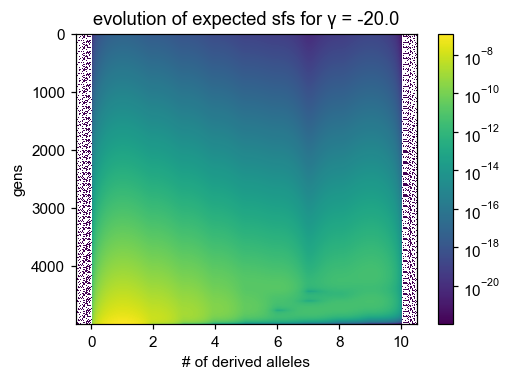

ValueError: zero-size array to reduction operation maximum which has no identity

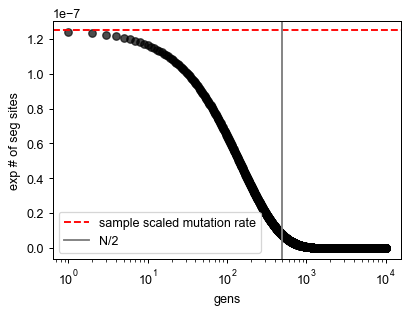

In [862]:
plt.imshow(np.abs(mom[-5000:,:]),aspect='auto',norm=colors.LogNorm())
plt.xlabel('# of derived alleles'); plt.ylabel('gens'); plt.title('evolution of expected sfs for γ = {}'.format(s*2*N))
plt.colorbar(); plt.show()
np.sum(mom<0)

plt.figure(dpi=90)
plt.scatter(np.arange(tot_gen+1)[::-1][-10000:],(np.sum(mom[-10000:,:],axis=1)),alpha=0.7,color='k')
plt.semilogx(); plt.xlabel('gens'); plt.ylabel('exp # of seg sites')
plt.axhline(n*mu, color='red', ls='--',label='sample scaled mutation rate')
plt.axvline(0.5*N, color='grey',label='N/2'); plt.legend()
plt.axvline(tot_gen-np.max(np.where(np.sum(mom,axis=1)<0)), color='coral', ls='-.')

In [848]:
mom[-8,:]

array([ 0.00000000e+00,  1.22293699e-07,  1.73037199e-10,  1.30073587e-13,
        1.92312614e-17, -4.67643843e-21,  8.83419952e-26, -3.62340113e-24,
       -5.25242433e-28, -7.51024739e-28,  0.00000000e+00])

In [640]:
g = -2
print(mom[g,] @ D)
print(D @ mom[g,])

[ 0.00000000e+00 -2.24274004e-06  1.99293846e-06  5.32211538e-10
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00]
[ 1.12148407e-06 -2.24256264e-06  1.12067308e-06  4.05494505e-10
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00]


In [485]:
# J @ mom[10,iter]
print(J)
# print(mom[10,iter])
print(mom[-4,iter])
J @ mom[-4, iter]

[[ 1.08791209 -0.2014652   0.03021978  0.          0.          0.
   0.          0.          0.        ]
 [ 0.06043956  1.00732601 -0.1510989   0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.1007326   0.99725275 -0.18131868  0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.1510989   0.96703297 -0.2014652   0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.21153846  0.91666667 -0.21153846
   0.          0.          0.        ]
 [ 0.          0.          0.         -0.21153846  0.91666667  0.21153846
   0.          0.          0.        ]
 [ 0.          0.          0.          0.         -0.2014652   0.96703297
   0.1510989   0.          0.        ]
 [ 0.          0.          0.          0.          0.         -0.18131868
   0.99725275  0.1007326   0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -0.1510989   1.00732601  0.06043956]
 [ 0.          0.      

array([ 1.34703236e-07,  7.56030734e-09,  7.61422413e-12,  2.86460452e-15,
        1.18823482e-19, -1.18823482e-19,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])

In [436]:
def calcJK13(n):
    J = np.zeros((n,n-1))
    for i in range(n):
        ibis = index_bis(i + 1, n) - 1
        J[i, ibis] = -(1.+n) * ((2.+i)*(2.+n)*(-6.-n+(i+1.)*(3.+n))-2.*(4.+n)*(-1.+(i+1.)*(2.+n))*(ibis+1.)+(12.+7.*n+n**2)*(ibis+1.)**2) / (2.+n) / (3.+n) / (4.+n)
        J[i, ibis - 1] = (1.+n) * (4.+(1.+i)**2*(6.+5.*n+n**2)-(i+1.)*(14.+9.*n+n**2)-(4.+n)*(-5.-n+2.*(i+1.)*(2.+n))*(ibis+1.)+(12.+7.*n+n**2)*(ibis+1.)**2) / (2.+n) / (3.+n) / (4.+n) / 2.
        J[i, ibis + 1] = (1.+n) * ((2.+i)*(2.+n)*(-2.+(i+1.)*(3.+n))-(4.+n)*(1.+n+2.*(i+1.)*(2.+n))*(ibis+1.)+(12.+7.*n+n**2)*(ibis+1.)**2) / (2.+n) / (3.+n) / (4.+n) / 2.
    return J

In [583]:
def calcD(d):
    res = np.zeros([d, d])
    # loop over the fs elements:
    for i in range(d):
        if i > 1:
            res[i, i - 1] = (i-1) * (d-i)
        if i < d - 2:
            res[i, i + 1] = (i+1) * (d-i-2)
        if i > 0 and i < d - 1:
            res[i, i] = -2 * i * (d-i-1)
    return res

In [642]:
D = 0.25/N * calcD(n+1)
# print(D.shape)
print(D)

[[ 0.       0.00045  0.       0.       0.       0.       0.       0.
   0.       0.       0.     ]
 [ 0.      -0.0009   0.0008   0.       0.       0.       0.       0.
   0.       0.       0.     ]
 [ 0.       0.00045 -0.0016   0.00105  0.       0.       0.       0.
   0.       0.       0.     ]
 [ 0.       0.       0.0008  -0.0021   0.0012   0.       0.       0.
   0.       0.       0.     ]
 [ 0.       0.       0.       0.00105 -0.0024   0.00125  0.       0.
   0.       0.       0.     ]
 [ 0.       0.       0.       0.       0.0012  -0.0025   0.0012   0.
   0.       0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.00125 -0.0024   0.00105
   0.       0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.0012  -0.0021
   0.0008   0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       0.00105
  -0.0016   0.00045  0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       0.
   0.0008  -0.0009   0.   

In [514]:
def calcS(d, ljk):
    # Computes the jackknife-transformed selection matrix 1
    # for the addition of a single sample
    # arrays for the creation of the sparse (coo) matrix
    # data will have matrix entry, row + column have coordinates
    data = []
    row = []
    col = []
    # loop over the fs elements:
    for i in range(d):
        i_bis = index_bis(i, d - 1) # This picks the second jackknife index 
        i_ter = index_bis(i + 1, d - 1) # This picks the third jackknife index
        # coefficients of the selection matrix
        g1 = i * (d-i) / np.float64(d)
        g2 = -(i+1) * (d-1-i) / np.float64(d)

        if i < d - 1 and i > 0: # First deal with non-fixed variants
            data += [g1 * ljk[i - 1, i_bis - 1], g1 * ljk[i - 1, i_bis - 2],
                    g1 * ljk[i - 1, i_bis], g2 * ljk[i, i_ter - 1],
                    g2 * ljk[i, i_ter - 2], g2 * ljk[i, i_ter]]
            row += 6 * [i]
            col += [i_bis, i_bis - 1, i_bis + 1,
                    i_ter, i_ter - 1, i_ter + 1]
        
        elif i == 0: # g1=0
            data += [g2 * ljk[i, i_ter - 1],
                     g2 * ljk[i, i_ter - 2], g2 * ljk[i, i_ter]]
            row += 3 * [i]
            col += [i_ter, i_ter - 1, i_ter + 1]
        
        elif i == d - 1: # g2=0
            data += [g1 * ljk[i - 1, i_bis - 1], g1 * ljk[i - 1, i_bis - 2],
                     g1 * ljk[i - 1, i_bis]]
            row += 3 * [i]
            col += [i_bis, i_bis - 1, i_bis + 1]

    return coo_matrix((data, (row, col)), shape=(d, d), dtype='float').tocsc()

In [641]:
# S = 0.5 * s * calcS(n+1, J)
print(S.shape)
S.todense()

(11, 11)


matrix([[ 0.00000000e+00,  2.47252747e-03, -4.57875458e-04,
          6.86813187e-05,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -2.22527473e-03,  4.57875458e-03,
         -6.86813187e-04,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -2.47252747e-04, -3.57142857e-03,
          6.05769231e-03, -9.89010989e-04,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00, -5.49450549e-04,
         -4.47802198e-03,  7.14285714e-03, -1.28205128e-03,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -9.61538462e-04, -4.71153846e-03,  

In [495]:
J = calcJK13(n)
ibis

[2, 2, 3, 4, 5, 5, 6, 7, 8, 8]

In [275]:
## testbed for a single realization of gen = t and looping over i
mom[tot_gen,1] = n*mu # singleton input

# going from generation 9 to 0
for gen in np.arange(tot_gen)[::-1]:

    # notice the difference in indexing for LHS
    for i in np.arange(1,n+1):
        ib = index_bis(i,n)
        momnp1[i] = np.abs(jk13[i-1,0] * mom[gen+1,ib-1] + jk13[i-1,1] * mom[gen+1,ib] + jk13[i-1,2] * mom[gen+1,ib+1])
    
    for i in np.arange(1,n):
        momkp1[gen,i] =  mom[gen+1,i] + 0.5 * s/(n+1) * (i * (n+1-i) * momnp1[i] - (n-i) * (i+1) * momnp1[i+1])

        if i==1:
            momkp1[gen,i] += 0.25/N * ((n-2) * 2 * mom[gen+1,2] -  2 * (n-1) * mom[gen+1,1])
        elif i==(n-1):
            momkp1[gen,i] += 0.25/N * ((n-2) * 2 * mom[gen+1,n-2] - 2 * (n-1) * mom[gen+1,n-1])
        else:
            momkp1[gen,i] += 0.25/N * (mom[gen+1,i-1] * (i-1)*(n-i+1) + mom[gen+1,i+1] * (i+1)*(n-i-1) - mom[gen+1,i] * 2*i*(n-i))   

        mom[gen,i] = momkp1[gen,i]

    # print(mom[gen,:])

In [449]:
# g = -4
# jk13[:,0] * mom[g,np.array(ibis)-1] + jk13[:,1] * mom[g,np.array(ibis)] + jk13[:,2] * mom[g,np.array(ibis)+1]
mom[-567,:]

array([ 0.00000000e+00,  5.34851574e-08,  2.32531104e-09,  6.53087058e-11,
        4.36925801e-13, -4.01973654e-14,  9.39025493e-14, -4.56777842e-14,
        1.96851081e-14, -5.31531012e-15,  0.00000000e+00])

In [471]:
# tot_gen - np.where(np.min(mom, axis=1) < 0)[0][-1]
mom[-8000,]

array([ 0.00000000e+00,  8.26360462e-17,  8.01006897e-18,  5.33154659e-19,
        1.32931259e-20,  1.05926070e-21, -2.35548945e-21, -8.44977046e-21,
       -5.17086593e-20, -4.00239756e-19,  0.00000000e+00])

In [176]:
## packaging into a function for easy manipulation 
# input: t (number of gens), n (number of samples), s, N (pop size)
# output: mom (gen x number of sites)
# 
def run_mom_framework(t, n, s, N, misc):
    mom = np.zeros((t+1,n+1))
    momnp1 = np.zeros(n+1)
    momkp1 = np.zeros(n+1)

    iter = np.arange(1,n)
    iterm1p1 = np.arange(2,n-1)

    mom[t,1] = n*mu # singleton input

    ibis = misc[0]
    jk13 = misc[1]

    # going from generation 9 to 0
    for gen in np.arange(t)[::-1]:
        momkp1[iterm1p1] = mom[gen+1,iterm1p1-1] * (iterm1p1-1)*(n-iterm1p1+1) + mom[gen+1,iterm1p1+1] * (iterm1p1+1)*(n-iterm1p1-1) - mom[gen+1,iterm1p1] * 2*iterm1p1*(n-iterm1p1)

        momkp1[1] = (n-2) * 2 * mom[gen+1,2] - 2 * (n-1) * mom[gen+1,1]
        momkp1[n-1] = (n-2) * 2 * mom[gen+1,n-2] - 2 * (n-1) * mom[gen+1,n-1]

        # notice the difference in indexing for LHS
        momnp1[np.arange(1,n+1)] = jk13[:,0] * mom[gen+1,np.array(ibis)-1] + jk13[:,1] * mom[gen+1,np.array(ibis)] + jk13[:,2] * mom[gen+1,np.array(ibis)+1]

        momkp1[iter] = mom[gen+1,iter] + 0.5 * s/(n+1) * (iter * (n+1-iter) * momnp1[iter] - (n-iter) * (iter+1) * momnp1[iter+1]) + 0.25/N * momkp1[iter] 

        # print(momnp1)
        
        mom[gen,:] = momkp1

    return mom           

In [154]:
# assuming that 250000 gens is enough
# ibis, jk13 = calcJK13(n)
mom = run_mom_framework(t=2500, n=10, s=s, N=5000, misc=[ibis, jk13])
mom2 = run_mom_framework(t=2500, n=10, s=2.5*s, N=5000, misc=[ibis, jk13])

In [77]:
print(np.sum(mom[-250000:,:]))
np.sum(mom[-10000:,:])
mom[-40000,:]

1.798803293873811e+60


array([   0.        , -346.49522637, -325.15334751, -486.83696922,
        829.90617692,  132.29001156,  200.3602747 ,  175.53959075,
        178.97332459,  181.82771781,    0.        ])

In [140]:
## shwoing that infinity is basically 20000 gens when s ≈ 1e-4 to 1e-6
plt.scatter(np.exp(np.linspace(1,np.log(250000))), [np.sum(mom[-int(x):,:]) for x in np.exp(np.linspace(1,np.log(250000)))], color='k', alpha=0.6,label='s=1e-7')
plt.scatter(np.exp(np.linspace(1,np.log(250000))), [np.sum(mom2[-int(x):,:]) for x in np.exp(np.linspace(1,np.log(250000)))], color='coral', alpha=0.6,label='s=1e-6')
plt.loglog(); plt.xlabel('number of gens'); plt.ylabel('sum of all entries'); plt.legend()

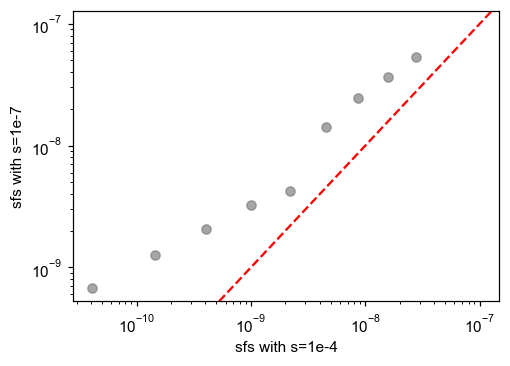

In [155]:
plt.scatter(mom[100,:], mom2[100,:], alpha=0.7, color='grey')
plt.xlabel('sfs with s=1e-4'); plt.ylabel('sfs with s=1e-7'); plt.loglog()
plt.axline((0,0),(1e-7,1e-7),color='red',ls='--')

In [196]:
## creating a database of P(X, a | s) with dicts for different s values
p_xa_s = {}
for g in gamma:
    p_xa_s[g] = run_mom_framework(t=25000, n=10, s=0.5*g/N, N=N, misc=[ibis, jk13])

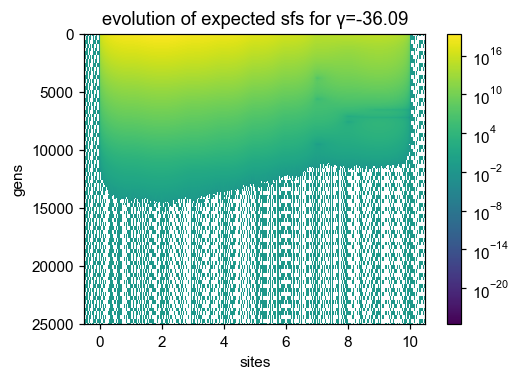

In [203]:
plt.imshow(p_xa_s[gamma[23]],aspect='auto',norm=colors.LogNorm())#vmax=10e-7,vmin=10e-30))
plt.xlabel('# of derived alleles'); plt.ylabel('gens'); 
plt.title('evolution of expected sfs for γ={:.2f}'.format(gamma[23])); plt.colorbar()

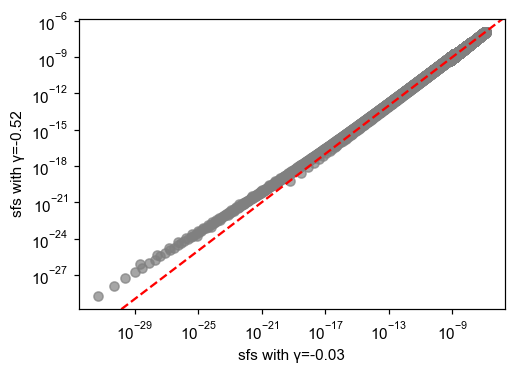

In [201]:
plt.scatter(p_xa_s[gamma[1]], p_xa_s[gamma[10]], alpha=0.7, color='grey')
plt.xlabel('sfs with γ={:.2f}'.format(gamma[1])); plt.ylabel('sfs with γ={:.2f}'.format(gamma[10])); plt.loglog()
plt.axline((0,0),(1e-7,1e-7),color='red',ls='--')

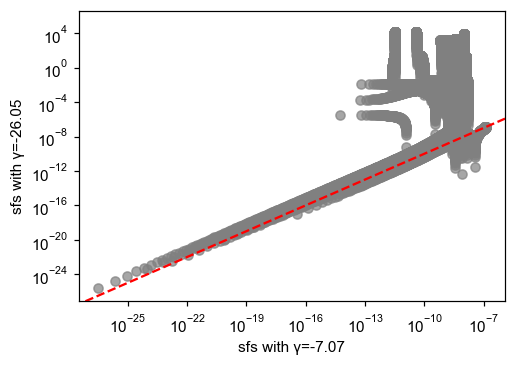

In [202]:
plt.scatter(p_xa_s[gamma[18]], p_xa_s[gamma[22]], alpha=0.7, color='grey')
plt.xlabel('sfs with γ={:.2f}'.format(gamma[18])); plt.ylabel('sfs with γ={:.2f}'.format(gamma[22])); plt.loglog()
plt.axline((0,0),(1e-7,1e-7),color='red',ls='--')